# Full simulation

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.99'
import sys
sys.path.append('/home/iiyama/src/lsh-qudit')
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy
import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as RuntimeEstimator, Batch
from qiskit_ibm_runtime.fake_provider import FakeTorino, FakeKawasaki
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as AerSampler, EstimatorV2 as AerEstimator
import lsh_qudit.set_rccx_inverse
from lsh_qudit.utils import QubitPlacement, sort_qubits, draw_circuit, clean_array, op_matrix
from lsh_qudit.hamiltonian import boundary_conditions
from lsh_qudit.trotter import trotter_step_circuit, trotter_step_unitary
from lsh_qudit.matrices import hamiltonian, nl_bounds
from lsh_qudit.precompiler import lsh_qudit_precompiler
from lsh_qudit.postcompiler import LSHPostcompiler
from lsh_qudit.layout import layout_heavy_hex, layout_candidates
from lsh_qudit.transpiler import get_layout, transpile_lsh_circuit

jax.config.update('jax_enable_x64', True)
jax.config.update('jax_default_device', jax.devices()[1])

In [19]:
num_sites = 4
tmax = 5.
num_steps = 20
num_steps_coarse = 4
mass_mu = 1.
interaction_x = 1.
time_step = tmax / num_steps
time_step_coarse = tmax / num_steps_coarse

tlist_trotter = np.linspace(0., tmax, num_steps + 1)
tlist_trotter_coarse = np.linspace(0., tmax, num_steps_coarse + 1)
tlist_ode = np.linspace(0., 5., 100)

initial_state = [0, 1, 0] + [0, 1, 1] + [0, 0, 2] + [1, 0, 1]

In [3]:
def energy_density_from_counts(counts, qp):
    """Compute the expectation value of H_E."""
    expval = np.zeros(3)
    for bitstr, count in counts.items():
        nvals = bitstr[::-1]
        ni = np.array([int(nvals[qp['i', site]]) for site in range(3)])
        no = np.array([int(nvals[qp['o', site]]) for site in range(3)])
        nl = np.array(
            [
                0,
                int(nvals[qp['l', 1]]),
                2 * int(nvals[qp['d1', 2]]) + int(nvals[qp['d0', 2]])
            ]
        )
        expval += (nl / 2. + nl * nl / 4. + (nl + 1.5) * no * (1 - ni) / 2.) * count
    expval /= sum(counts.values())
    return expval

def energy_density(probs, shape):
    dim = np.prod(shape)
    offsets = np.cumprod((1,) + shape[:0:-1])[::-1]
    nvals = (np.arange(dim)[:, None] // offsets[None, :]) % np.array(shape)[None, :]
    nvals = np.flip(nvals, axis=1)
    ni = nvals[:, ::3]
    no = nvals[:, 1::3]
    nl = nvals[:, 2::3]
    site_energy_densities = (nl / 2. + nl * nl / 4. + (nl + 1.5) * no * (1 - ni) / 2.)
    extra_dims = tuple(range(probs.ndim - 1))
    expval = np.sum(probs[..., None] * np.expand_dims(site_energy_densities, extra_dims), axis=-2)
    return expval


In [4]:
def energy_density_observables(qp):
    identity = SparsePauliOp('I')
    p0 = SparsePauliOp(['I', 'Z'], [0.5, 0.5])
    p1 = SparsePauliOp(['I', 'Z'], [0.5, -0.5])

    observables = []

    # Site 0
    ops = [identity] * qp.num_qubits
    ops[qp['i', 0]] = p0
    ops[qp['o', 0]] = p1
    he3f = ops[0]
    for op in ops[1:]:
        he3f = op.tensor(he3f)
    observables.append((he3f * 0.75).simplify())
    
    # Site 1
    ops = [identity] * qp.num_qubits
    ops[qp['l', 1]] = p1
    nl = ops[0]
    for op in ops[1:]:
        nl = op.tensor(nl)
    ops = [identity] * qp.num_qubits
    ops[qp['i', 1]] = p0
    ops[qp['o', 1]] = p1
    he3f = ops[0]
    for op in ops[1:]:
        he3f = op.tensor(he3f)
    observables.append((nl * 0.5 + nl.dot(nl) * 0.25 + nl.dot(he3f) * 0.5 + he3f * 0.75).simplify())

    # Site 2
    ops = [identity] * qp.num_qubits
    ops[qp['d0', 2]] = p1
    nl0 = ops[0]
    for op in ops[1:]:
        nl0 = op.tensor(nl0)
    ops = [identity] * qp.num_qubits
    ops[qp['d1', 2]] = p1
    nl1 = ops[0]
    for op in ops[1:]:
        nl1 = op.tensor(nl1)
    nl = (nl0 + nl1 * 2).simplify()
    ops = [identity] * qp.num_qubits
    ops[qp['i', 2]] = p0
    ops[qp['o', 2]] = p1
    he3f = ops[0]
    for op in ops[1:]:
        he3f = op.tensor(he3f)
    observables.append((nl * 0.5 + nl.dot(nl) * 0.25 + nl.dot(he3f) * 0.5 + he3f * 0.75).simplify())

    return observables

## Analytical results (Exact solution + Trotter)

In [ ]:
hmat = hamiltonian(num_sites, mass_mu, interaction_x,
                   max_left_flux=0, max_right_flux=1, npmod=jnp)

def dpsidt(state, t):
    return -1.j * hmat @ state

conditions = boundary_conditions(num_sites, 0, 1)
shape = ()
for bc in conditions:
    shape = (nl_bounds(**bc)[1], 2, 2) + shape
dim = np.prod(shape)
offsets = np.cumprod((1,) + shape[:0:-1])[::-1]
idx = np.sum(offsets * np.array(initial_state[::-1]))
psi0 = np.zeros(dim, dtype=np.complex128)
psi0[idx] = 1.

# Solve the Schrodinger equation
states_ode = odeint(dpsidt, psi0, tlist_ode)
probs = np.square(np.abs(states_ode))
# Integrate the site 4 dimensions
probs = np.sum(probs.reshape(-1, np.prod(shape[:3]), np.prod(shape[3:])), axis=1)
expval_ode = energy_density(probs, shape[3:])

# Compound the single-step unitary
umat = trotter_step_unitary(num_sites, time_step, mass_mu, interaction_x,
                            max_left_flux=0, max_right_flux=1, npmod=jnp)
states_trotter = np.empty((num_steps + 1, dim), dtype=np.complex128)
states_trotter[0] = psi0
for istep in range(num_steps):
    states_trotter[istep + 1] = umat @ jnp.array(states_trotter[istep])
probs = np.square(np.abs(states_trotter))
probs = np.sum(probs.reshape(-1, np.prod(shape[:3]), np.prod(shape[3:])), axis=1)
expval_trotter = energy_density(probs, shape[3:])


In [24]:
# Coarse trotter
umat = trotter_step_unitary(num_sites, time_step_coarse, mass_mu, interaction_x,
                            max_left_flux=0, max_right_flux=1, npmod=jnp)
states_trotter_coarse = np.empty((num_steps_coarse + 1, dim), dtype=np.complex128)
states_trotter_coarse[0] = psi0
for istep in range(num_steps_coarse):
    states_trotter_coarse[istep + 1] = umat @ jnp.array(states_trotter_coarse[istep])
probs = np.square(np.abs(states_trotter_coarse))
probs = np.sum(probs.reshape(-1, np.prod(shape[:3]), np.prod(shape[3:])), axis=1)
expval_trotter_coarse = energy_density(probs, shape[3:])

In [6]:
def make_trotter_circuit(tmax, num_steps, mass_mu, interaction_x,
                         second_order=False, backend=None, measure=True, statevector=False):
    time_step = tmax / num_steps
    
    qp = QubitPlacement(
        [('o', 0), ('i', 0)]
        + [('i', 1), ('l', 1), ('o', 1)]
        + [('l', 2), ('o', 2), ('i', 2)]
        + [('i', 3), ('l', 3), ('o', 3)]
        + [('d0', 2), ('d1', 2)]
    )
    trotter_step = trotter_step_circuit(4, time_step, mass_mu, interaction_x, qp=qp,
                                        max_left_flux=0, max_right_flux=1,
                                        second_order=second_order)[0]
    readout_order = (
        [('i', 0), ('o', 0)]
        + [('i', 1), ('o', 1), ('l', 1)]
        + [('i', 2), ('o', 2), ('d0', 2), ('d1', 2)]
    )

    if backend is None:
        layout = list(range(qp.num_qubits))
        precompile_pm = lsh_qudit_precompiler()
        trotter_step_tr = precompile_pm.run(trotter_step)
    else:
        layout = get_layout(trotter_step, qp, backend)
        trotter_step_tr = transpile_lsh_circuit(trotter_step, backend, layout=layout)

    if statevector:
        rewired_qp = QubitPlacement(readout_order + [('i', 3), ('o', 3), ('l', 3), ('l', 2)])
        rewired = QuantumCircuit(qp.num_qubits)
        rewired.compose(trotter_step_tr, qubits=[rewired_qp[lab] for lab in qp.qubit_labels],
                        inplace=True)
        qp = rewired_qp
        trotter_step_tr = rewired
    elif measure:
        meas_qubits = [layout[qp[lab]] for lab in readout_order]

    args = [QuantumRegister(qp.num_qubits, name='q')]
    if not statevector and measure:
        args.append(ClassicalRegister(len(readout_order), name='meas'))
    circuit = QuantumCircuit(*args)

    for site in range(4):
        for iname, name in enumerate(['i', 'o']):
            if initial_state[site * 3 + iname] == 1:
                circuit.x(qp[name, site])
        if site == 2:
            match initial_state[site * 3 + 2]:
                case 1:
                    circuit.x(qp['d0', site])
                case 2:
                    circuit.x(qp['d1', site])
                case 3:
                    circuit.x([qp['d0', site], qp['d1', site]])
        else:
            if initial_state[site * 3 + 2] == 1:
                circuit.x(qp['l', site])

    if backend is not None:
        circuit = transpile(circuit, backend=backend, initial_layout=layout)

    circuits = []
    for _ in range(num_steps):
        circ = circuit.copy()
        if statevector:
            circ.save_statevector()
        elif measure:
            circ.measure(meas_qubits, range(circ.num_clbits))
        circuits.append(circ)
        circuit.compose(trotter_step_tr, inplace=True)
    if statevector:
        circuit.save_statevector()
    elif measure:
        circuit.measure(meas_qubits, range(circuit.num_clbits))
    circuits.append(circuit)

    return circuits, qp

## First-order Trotter

### Statevector simulator

In [7]:
circuits, qp = make_trotter_circuit(tmax, num_steps, mass_mu, interaction_x, statevector=True)
simulator = AerSimulator(device='GPU')
sim_result = simulator.run(circuits).result()
probs = np.empty((num_steps + 1, 2 ** (qp.num_qubits - 4)))
for ires in range(len(circuits)):
    res_probs = np.square(np.abs(clean_array(sim_result.get_statevector(ires).data)))
    probs[ires] = np.sum(res_probs.reshape(2 ** 4, -1), axis=0)

expval_svsim = energy_density(probs, shape[3:])

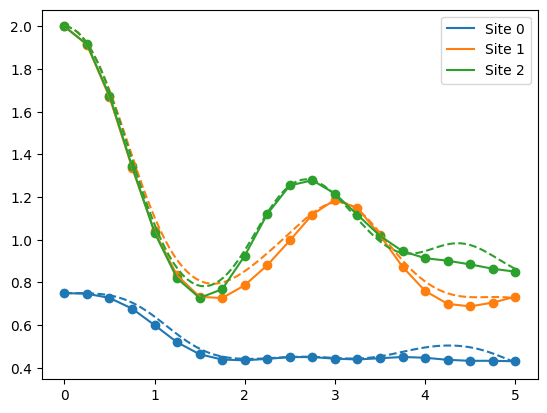

In [8]:
for site in range(3):
    line, = plt.plot(tlist_trotter, expval_trotter[:, site], label=f'Site {site}')
    plt.plot(tlist_ode, expval_ode[:, site], color=line.get_color(), linestyle='--')
    plt.scatter(tlist_trotter, expval_svsim[:, site], color=line.get_color(), marker='o')
plt.legend()

### Statevector simulator (with measurements)

In [9]:
circuits, qp = make_trotter_circuit(tmax, num_steps, mass_mu, interaction_x)
sampler = AerSampler(default_shots=100000, options={'backend_options': {'device': 'GPU'}})
sim_result = sampler.run(circuits).result()
probs = np.zeros((num_steps + 1, 2 ** (qp.num_qubits - 4)))
for ires, res in enumerate(sim_result):
    counts = res.data.meas.get_int_counts()
    probs[ires, list(counts.keys())] = list(counts.values())
    probs[ires] /= res.data.meas.num_shots

expval_sampsim = energy_density(probs, shape[3:])

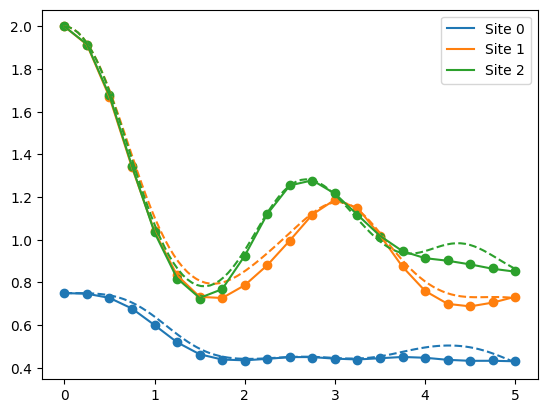

In [10]:
for site in range(3):
    line, = plt.plot(tlist_trotter, expval_trotter[:, site], label=f'Site {site}')
    plt.plot(tlist_ode, expval_ode[:, site], color=line.get_color(), linestyle='--')
    plt.scatter(tlist_trotter, expval_sampsim[:, site], color=line.get_color(), marker='o')
plt.legend()

### Statevector simulator (using Estimator)

In [11]:
circuits, qp = make_trotter_circuit(tmax, num_steps, mass_mu, interaction_x, measure=False)
estimator = AerEstimator(options={'backend_options': {'device': 'GPU'}})
sim_result = estimator.run([(circ, energy_density_observables(qp)) for circ in circuits]).result()

expval_estsim = np.array([res.data.evs for res in sim_result])

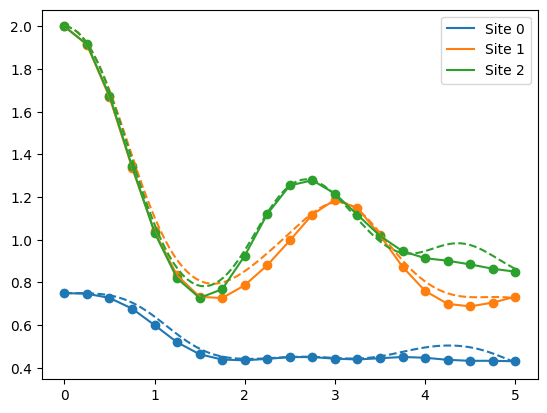

In [12]:
for site in range(3):
    line, = plt.plot(tlist_trotter, expval_trotter[:, site], label=f'Site {site}')
    plt.plot(tlist_ode, expval_ode[:, site], color=line.get_color(), linestyle='--')
    plt.scatter(tlist_trotter, expval_estsim[:, site], color=line.get_color(), marker='o')
plt.legend()

### IBM backend

In [14]:
service = QiskitRuntimeService(instance='ibm-q-utokyo/internal/terashi-sr')
backend = service.backend('ibm_marrakesh')

In [ ]:
circuits, qp = make_trotter_circuit(tmax, num_steps_coarse, mass_mu, interaction_x, backend=backend, measure=False)
observables = [obs.apply_layout(circuits[0].layout) for obs in energy_density_observables(qp)]

In [ ]:
# jobs = [service.job('czhqv44fcch0008ath3g')]
# with Batch(backend=backend) as batch:
#     for circuit in circuits[1:]:
#         estimator = RuntimeEstimator(batch)
#         jobs.append(estimator.run([(circuit, observables)]))
# result_data = [job.result()[0].data for job in jobs]

import json
from qiskit_ibm_runtime import RuntimeDecoder

with open('/data/iiyama/lsh_qudit/marrakesh_mar26.json', 'r') as source:
    result_data = json.load(source, cls=RuntimeDecoder)

In [65]:
expval_est = np.array([data.evs for data in result_data])
err_est = np.array([data.stds for data in result_data])

Text(0, 0.5, 'Electric energy density')

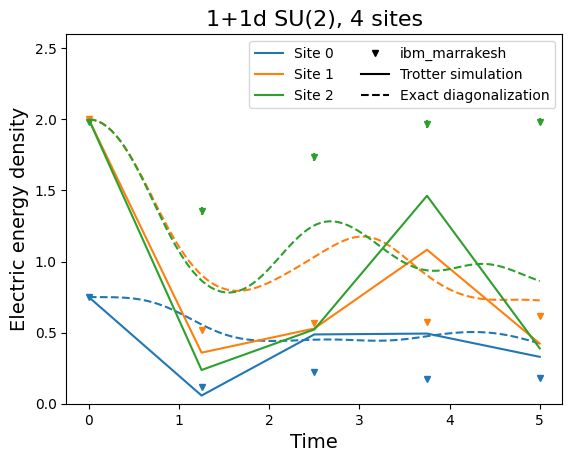

In [66]:
from matplotlib.lines import Line2D

lines = []
for site in range(3):
    line, = plt.plot(tlist_trotter_coarse, expval_trotter_coarse[:, site])
    lines.append(line)
    plt.plot(tlist_ode, expval_ode[:, site], color=line.get_color(), linestyle='--')
    plt.errorbar(tlist_trotter_coarse, expval_est[:, site], yerr=err_est[:, site],
                 color=line.get_color(), marker='v', markersize=4., linestyle='none')

plt.ylim(0., 2.6)

markers = Line2D([], [], linestyle='none', marker='v', markersize=4., color='k')
solid_line = Line2D([], [], linewidth=line.get_linewidth(), linestyle='-', color='k', marker='none')
dashed_line = Line2D([], [], linewidth=line.get_linewidth(), linestyle='--', color='k', marker='none')
plt.legend(lines + [markers, solid_line, dashed_line],
           [f'Site {i}' for i in range(3)] + [backend.name, 'Trotter simulation', 'Exact diagonalization'],
           loc='upper right',
           ncols=2)
plt.title('1+1d SU(2), 4 sites', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Electric energy density', fontsize=14)